In [1]:
from itertools import islice

# import multiprocessing
# multiprocessing.set_start_method('fork')

import matplotlib.pyplot as plt
import numpy as np
import networkx as nx
from networkx.classes.function import path_weight
from scipy.optimize import curve_fit

from tqdm import tqdm

In [2]:
def path_to_bit_rep(p, G):
    p = [(v, p[i+1]) for i, v in enumerate(p[:-1])]
    
    bit_rep = []
    for e in G.edges():
        if (e[0], e[1]) in p:
            bit_rep.append(1)
        else:
            bit_rep.append(0)
    
    return np.array(bit_rep)


def compute_dH(p0, p1, G):
    p0 = path_to_bit_rep(p0, G)
    p1 = path_to_bit_rep(p1, G)
    
    return np.abs(p0 - p1).sum()


def sp(ns, W):
    G = nx.grid_2d_graph(3, ns+1)
    G = nx.DiGraph(G)
    for edge in G.copy().edges():
        if edge != tuple(sorted(edge)):
            G.remove_edge(*edge)

    source = (0, 0)
    target = (2, ns)

    for i, e in enumerate(G.edges()):
        G[e[0]][e[1]]['weight'] = W[i]
    
    p0, p1 = list(islice(nx.shortest_simple_paths(G, source, target, weight="weight"), 2))
    delta = path_weight(G, p1, weight="weight") - path_weight(G, p0, weight="weight")
#     dH = compute_dH(p0, p1, G)

    return delta # , dH

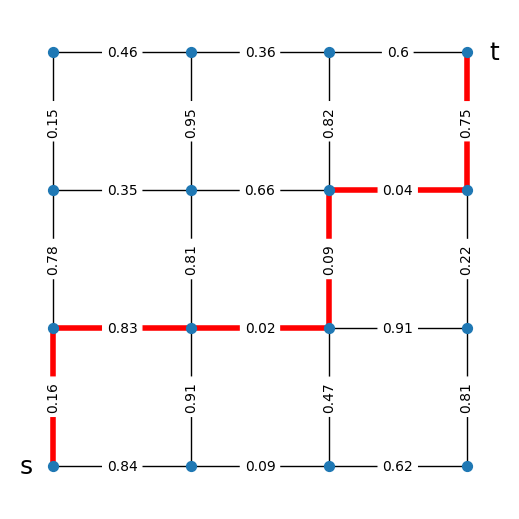

In [30]:
ns = 3
G = nx.grid_2d_graph(4, ns+1)
# G = nx.DiGraph(G)
# for edge in G.copy().edges():
#     if edge != tuple(sorted(edge)):
#         G.remove_edge(*edge)

pos = {}
for i in range(ns+1):
    pos[(0, i)] = np.array([i, 0.])
    pos[(1, i)] = np.array([i, 0.5])
    pos[(2, i)] = np.array([i, 1])
    pos[(3, i)] = np.array([i, 1.5])

labels = {(0, 0):"s", (3, 3):"t"}

W = np.random.random(G.number_of_edges())
for i, e in enumerate(G.edges()):
    G[e[0]][e[1]]['weight'] = W[i]

W = np.round(W, 2)

source = (0, 0)
target = (3, ns)

p0, p1 = list(islice(nx.shortest_simple_paths(G, source, target, weight="weight"), 2))
p0_edges = [(n, p0[i+1]) for i, n in enumerate(p0[:-1])]
p1_edges = [(n, p1[i+1]) for i, n in enumerate(p1[:-1])]

edges = list(G.edges())
edge_list = [e for e in edges if (e not in p0_edges)]# and (e not in p1_edges)]

plt.figure(figsize=(5, 5))
nx.draw(G, pos=pos, edgelist=edge_list, node_size=50)

pos[(0, 0)] = (-0.2, 0)
pos[(3, 3)] = (3.2, 1.5)

nx.draw_networkx_labels(G, pos, labels=labels, font_size=18)

pos = {}
for i in range(ns+1):
    pos[(0, i)] = np.array([i, 0.])
    pos[(1, i)] = np.array([i, 0.5])
    pos[(2, i)] = np.array([i, 1])
    pos[(3, i)] = np.array([i, 1.5])

nx.draw_networkx_edges(G, pos=pos, edgelist=p0_edges, edge_color="red", width=4)
# nx.draw_networkx_edges(G, pos=pos, edgelist=p1_edges, edge_color="green", width=4)

labels = {e: W[i] for i, e in enumerate(G.edges)}
nx.draw_networkx_edge_labels(G, pos, edge_labels=labels);

plt.savefig("plots/ssp.pdf")

In [4]:
ns_max = 12

to_compute = False
if to_compute:
    M = 10000

    df = np.zeros((ns_max, 2))
    for ns in range(1, ns_max+1):
        N = 5*ns + 2
        dfM = np.zeros(M)
        W = np.random.rand(N, M)
        for m in tqdm(range(M)):
            dfM[m] = sp(ns, W[:, m])
        df[ns-1] = (dfM.mean(), dfM.std(ddof=1) / M**0.5)

    np.save("data/2rows/deltaF.npy", df)
    
delta_f = np.load("data/2rows/deltaF.npy")
df = np.load("data/2rows/2rows.npy")

[1.29263267 0.86221898 0.13322374]
[0.08154877 0.03601499 0.00387658]


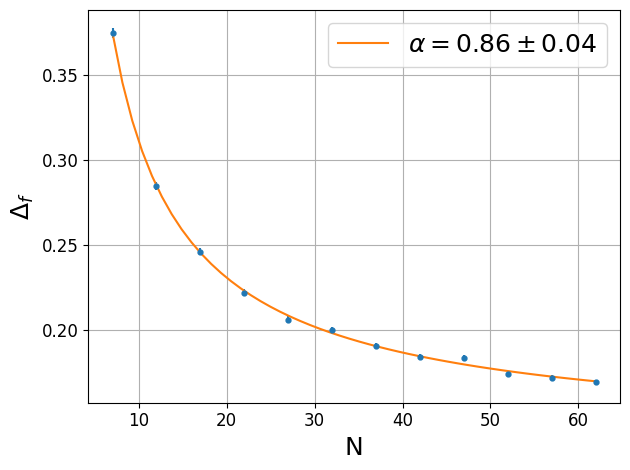

In [5]:
f_fit = lambda x, a, b, c: a / x**b + c

N = [5*ns + 2 for ns in range(1, 13)]
x = np.linspace(N[0], max(N))

plt.errorbar(N, delta_f[:, 0], yerr=delta_f[:, 1], fmt=".", ms=7)
popt, pcov = curve_fit(f_fit, N, delta_f[:, 0], sigma=delta_f[:, 1], p0=[0.5, 0.5, 1], 
                       bounds=[(0, 0, 0), (np.inf, np.inf, np.inf)], maxfev=10000)
plt.plot(x, f_fit(x, *popt), label=f"$\\alpha = {popt[1]:.2f} \pm {np.sqrt(pcov[1,1]):.2f}$")
plt.xlabel("N", fontsize=18)
plt.ylabel("$\Delta_f$", fontsize=18)
plt.legend(prop={'size': 18})
plt.grid()

plt.xticks(fontsize=12)
plt.yticks(fontsize=12)

plt.tight_layout()
# plt.savefig("plots/2rows_deltaf.pdf")

print(popt)
print(np.sqrt(np.diag(pcov)))

[0.1646899  0.03635153]
[0.00336089 0.00257422]


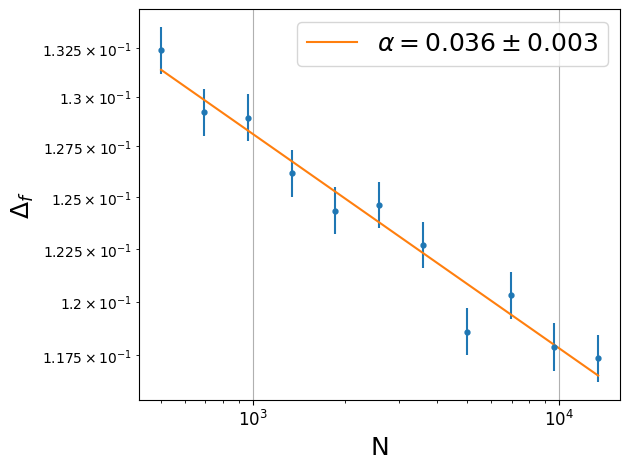

In [6]:
f_fit = lambda x, a, b: a / x**b

N = df[:, 0]
x = np.linspace(N[0], max(N))

plt.errorbar(N, df[:, 1], yerr=df[:, 2], fmt=".", ms=7)
popt, pcov = curve_fit(f_fit, N, df[:, 1], sigma=df[:, 2], p0=[0.1, 0.5], maxfev=10000,
                       bounds=([0, 0], [np.inf, np.inf]))

plt.plot(x, f_fit(x, *popt), label=f"$\\alpha = {popt[1]:.3f} \pm {np.sqrt(pcov[1,1]):.3f}$")
plt.xscale("log")
plt.yscale("log")
plt.xlabel("N", fontsize=18)
plt.ylabel("$\Delta_f$", fontsize=18)
plt.legend(prop={'size': 18})
plt.grid()

plt.xticks(fontsize=12)
plt.yticks(fontsize=12)

plt.tight_layout()
# plt.savefig("plots/2rows_df.pdf")

print(popt)
print(np.sqrt(np.diag(pcov)))

In [7]:
import h5py

ns_max = 8
sc = np.zeros((ns_max, 2))
dmin = np.zeros((ns_max, 2))
overlap = np.zeros((ns_max, 2))

for ns in range(ns_max):
    f = h5py.File(f"data/2rows/ns={ns+1}.jld", "r")
    scM, dminM = np.array(f["scM"]), np.array(f["dminM"])
    overlapM = np.array(f["overlapM"])
    
    scM = scM[(scM != 0) & (overlapM > 0.01)]
    dminM = dminM[(dminM != 0) & (overlapM > 0.01)]
    overlapM = overlapM[(overlapM != 0 & (overlapM > 0.01))]
    M = scM.shape[0]
    print(M)
    
    sc[ns] = np.mean(scM), np.std(scM, ddof=1) / np.sqrt(M)
    dmin[ns] = np.mean(dminM), np.std(dminM, ddof=1) / np.sqrt(M)
    overlap[ns] = np.mean(overlapM), np.std(overlapM, ddof=1) / np.sqrt(M)

2500
2500
2500
1000
1000
1006
986
986


In [8]:
N = np.array([5*ns+2 for ns in range(1, ns_max+3)])

B = 1
A = N.copy()

delta_f = delta_f[:ns_max+2, :]

first_order = np.zeros(delta_f.shape)
first_order[:, 0] = 2 * B*delta_f[:, 0] / (B*delta_f[:, 0] + A+2)
first_order[:, 1] = 2*(A+2) / (B*delta_f[:, 0] + A+2)**2 * B*delta_f[:, 1]

[1.45029602 1.28761444 0.00665935]
[0.46571897 0.14473619 0.00308583]


[9.94677705e-01 1.30464900e+00 7.89314757e-04]
[0.15897761 0.06082129 0.00051032]


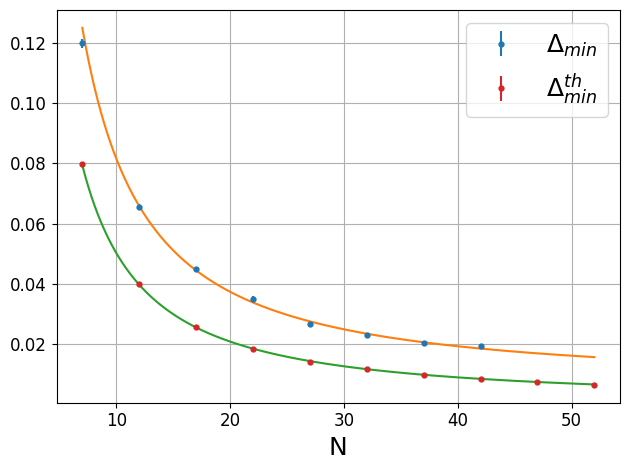

In [9]:
f_fit = lambda x, a, b, c: a / x**b + c

plt.errorbar(N[:ns_max], dmin[:, 0], yerr=dmin[:ns_max, 1], fmt=".", ms=7, label="$\Delta_{min}$")

x = np.linspace(N[0], N[-1], 1000)
popt, pcov = curve_fit(f_fit, N[1:ns_max], dmin[1:ns_max, 0], sigma=dmin[1:ns_max, 1], p0=[1, 1, 0.15],
                       bounds=([0, 0, 0], [np.inf, np.inf, np.inf]))
plt.plot(x, f_fit(x, *popt))
print(popt)
print(np.sqrt(np.diag(pcov)))
print("\n")

x = np.linspace(N[0], N[-1], 1000)
popt, pcov = curve_fit(f_fit, N[2:], first_order[2:, 0], sigma=first_order[2:, 1], p0=[1, 1, 0.1],
                       bounds=([0, 0, 0], [np.inf, np.inf, np.inf]))
plt.plot(x, f_fit(x, *popt))
print(popt)
print(np.sqrt(np.diag(pcov)))

plt.errorbar(N, first_order[:, 0], yerr=first_order[:, 1], fmt=".", ms=7, label="$\Delta_{min}^{th}$")

plt.xlabel("N", fontsize=18)
plt.legend(prop={'size': 18})
plt.grid()

plt.xticks(fontsize=12)
plt.yticks(fontsize=12)

plt.tight_layout()
# plt.savefig("plots/2rows_dmin.pdf")

[0.2485429  0.98118318 0.00357051]
[0.06324216 0.14326002 0.00213847]


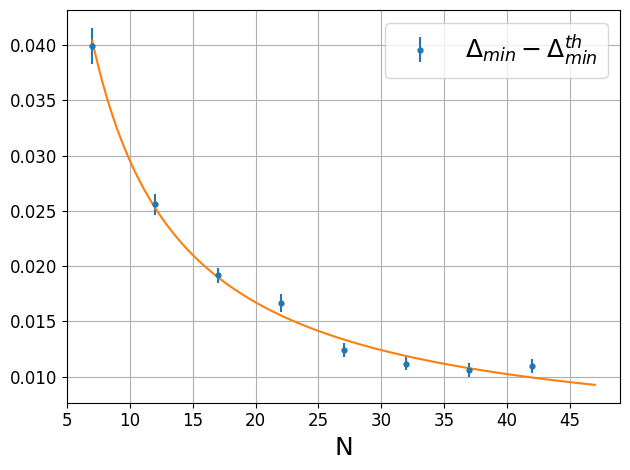

In [10]:

f_fit = lambda x, a, b, c: a / x**b + c

dd = dmin[:, 0] - first_order[:ns_max, 0]
dd_err = np.sqrt(dmin[:, 1]**2 + first_order[:ns_max, 1]**2)
plt.errorbar(N[:ns_max], dd, yerr=dd_err, fmt=".", ms=7, label="$\Delta_{min} - \Delta_{min}^{th}$")

popt, pcov = curve_fit(f_fit, N[:ns_max], dd, sigma=dd_err, p0=[0.3, 0.5, 2], absolute_sigma=True, maxfev=5000)
x = np.linspace(N[0], N[ns_max], 1000)
plt.plot(x, f_fit(x, *popt))
print(popt)
print(np.sqrt(np.diag(pcov)))

plt.xlabel("N", fontsize=18)
plt.legend(prop={'size': 18})
plt.grid()

plt.xticks(fontsize=12)
plt.yticks(fontsize=12)

plt.tight_layout()
# plt.savefig("plots/2rows_ddmin.pdf")

4.186550320171359 0.8533445683385462 6.395993219962145
2.1012009830382814 1.010741722594093 2.697768864633194
[0.2113813  0.02496097 0.70174384]


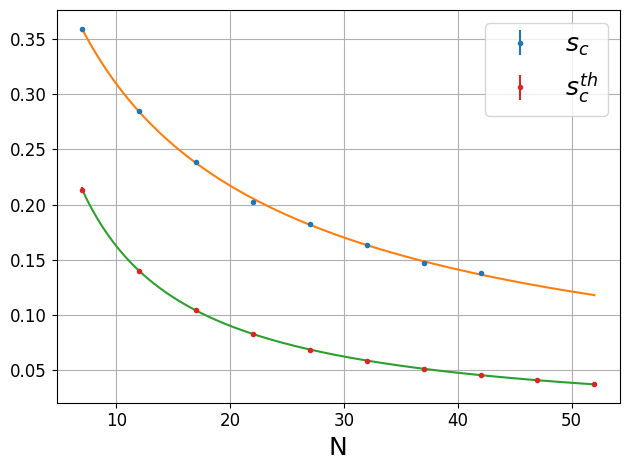

In [11]:
f_fit = lambda x, a, b, c: a / (x**b + c)

plt.errorbar(N[:ns_max], sc[:, 0], fmt='.', yerr=sc[:, 1], label="$s_c$")
x = np.linspace(N[0], N[ns_max+1], 200)
popt, pcov = curve_fit(f_fit, N[:ns_max], sc[:, 0], sigma=sc[:, 1], 
                       p0=[0.1, 1, 0.1], bounds=[(0, 0, 0), (np.inf, np.inf, np.inf)])
print(*popt)
plt.plot(x, f_fit(x, *popt))

sc_first = first_order[:, 0] / delta_f[:, 0]
dsc_first = np.sqrt((first_order[:, 1]/first_order[:, 0])**2 + (delta_f[:, 1]/delta_f[:, 0])**2) * sc_first

popt, pcov = curve_fit(f_fit, N, sc_first, maxfev=10000,
                       sigma=dsc_first, p0=[1, 0.1, 0.1], absolute_sigma=True,
                       bounds=[(0, 0, 0), (np.inf, np.inf, np.inf)])
print(*popt)
print(np.sqrt(np.diag(pcov)))
plt.plot(x, f_fit(x, *popt))

plt.errorbar(N, sc_first, yerr=dsc_first, fmt='.', label="$s_c^{th}$")

plt.legend(prop={'size': 18})
plt.xlabel("N", fontsize=18)
plt.grid()

plt.xticks(fontsize=12)
plt.yticks(fontsize=12)

plt.tight_layout()
# plt.savefig("plots/2rows_sc.pdf")

(array([0.08, 0.09, 0.1 , 0.11, 0.12, 0.13, 0.14, 0.15, 0.16]),
 [Text(0, 0.08, '0.08'),
  Text(0, 0.09, '0.09'),
  Text(0, 0.1, '0.10'),
  Text(0, 0.11, '0.11'),
  Text(0, 0.12, '0.12'),
  Text(0, 0.13, '0.13'),
  Text(0, 0.14, '0.14'),
  Text(0, 0.15000000000000002, '0.15'),
  Text(0, 0.16, '0.16')])

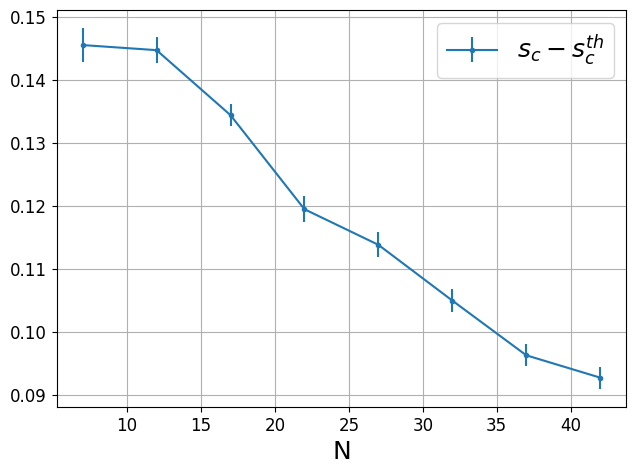

In [12]:
d_sc = sc[:, 0] - sc_first[:ns_max]
dd_sc = np.sqrt(sc[:, 1]**2 + dsc_first[:ns_max]**2)
plt.errorbar(N[:ns_max], d_sc, yerr=dd_sc, fmt=".-", label="$s_c - s_c^{th}$")
plt.legend(prop={'size': 18})
plt.xlabel("N", fontsize=18)
plt.tight_layout()
plt.grid()

plt.xticks(fontsize=12)
plt.yticks(fontsize=12)

# plt.savefig("plots/2rows_dsc.pdf")

In [13]:
np.save(f"data/2rows/N.npy", N[:ns_max])
np.save(f"data/2rows/sc.npy", sc)
np.save(f"data/2rows/dmin.npy", dmin)
np.save(f"data/2rows/ddmin.npy", np.vstack((dd, dd_err)).T)
np.save(f"data/2rows/dsc.npy", np.vstack((d_sc, dd_sc)).T)